# MAP parameter estimation for an LG-SSM using EM and SGD




## Setup

In [1]:
%%capture
import sys
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    #%pip install -q dynamax[notebooks]
    #import dynamax
    sys.path.append('../../..') 
    import dynamax

In [2]:
from jax import numpy as jnp
import jax.random as jr
from matplotlib import pyplot as plt

from dynamax.linear_gaussian_ssm import LinearGaussianConjugateSSM
from dynamax.utils.utils import monotonically_increasing

sys.path.append("../../..")
from src.utils.plotting import *

## Data



(0.0, 99.0)

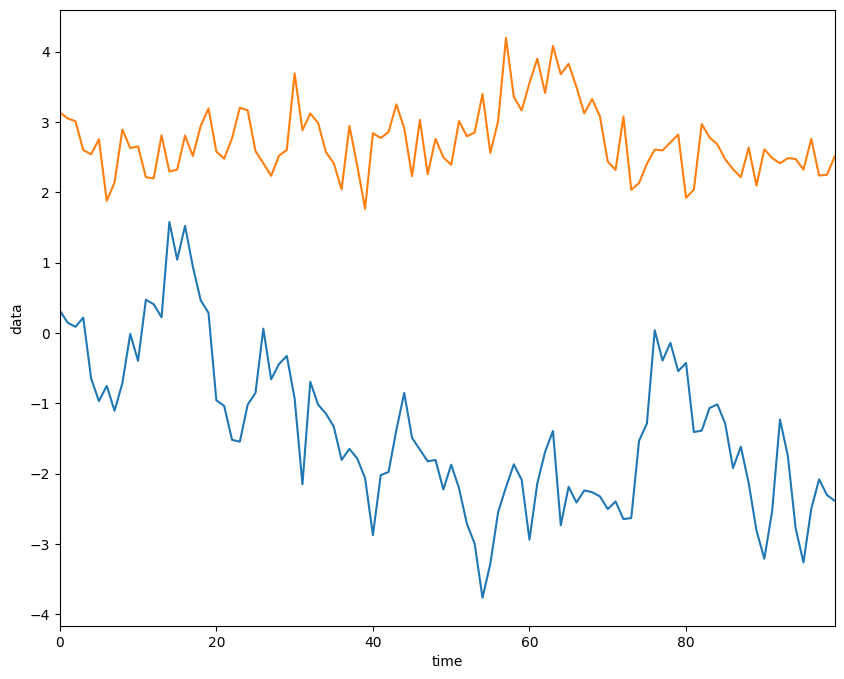

In [3]:
state_dim=2
emission_dim=2
num_timesteps=100
key = jr.PRNGKey(0)

true_model = LinearGaussianConjugateSSM(state_dim, emission_dim)
key, key_root = jr.split(key)
true_params, param_props = true_model.initialize(key)

key, key_root = jr.split(key)
true_states, emissions = true_model.sample(true_params, key, num_timesteps)

# Plot the true states and emissions
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(emissions + 3 * jnp.arange(emission_dim))
ax.set_ylabel("data")
ax.set_xlabel("time")
ax.set_xlim(0, num_timesteps - 1)

## Plot results

In [4]:
def plot_learning_curve(marginal_lls, true_model, true_params, test_model, test_params, emissions):
    plt.figure()
    plt.xlabel("iteration")
    nsteps = len(marginal_lls)
    plt.plot(marginal_lls, label="estimated")
    true_logjoint = (true_model.log_prior(true_params) + true_model.marginal_log_prob(true_params, emissions))
    plt.axhline(true_logjoint, color = 'k', linestyle = ':', label="true")
    plt.ylabel("marginal joint probability")
    plt.legend()

In [5]:
def plot_predictions(true_model, true_params, test_model, test_params, emissions):
    smoothed_emissions, smoothed_emissions_std = test_model.posterior_predictive(test_params, emissions)

    spc = 3
    plt.figure(figsize=(10, 4))
    for i in range(emission_dim):
        plt.plot(emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
        ln = plt.plot(smoothed_emissions[:, i] + spc * i,
                        label="smoothed" if i == 0 else None)[0]
        plt.fill_between(
            jnp.arange(num_timesteps),
            spc * i + smoothed_emissions[:, i] - 2 * smoothed_emissions_std[i],
            spc * i + smoothed_emissions[:, i] + 2 * smoothed_emissions_std[i],
            color=ln.get_color(),
            alpha=0.25,
        )
    plt.xlabel("time")
    plt.xlim(0, num_timesteps - 1)
    plt.ylabel("true and predicted emissions")
    plt.legend()
    plt.show()

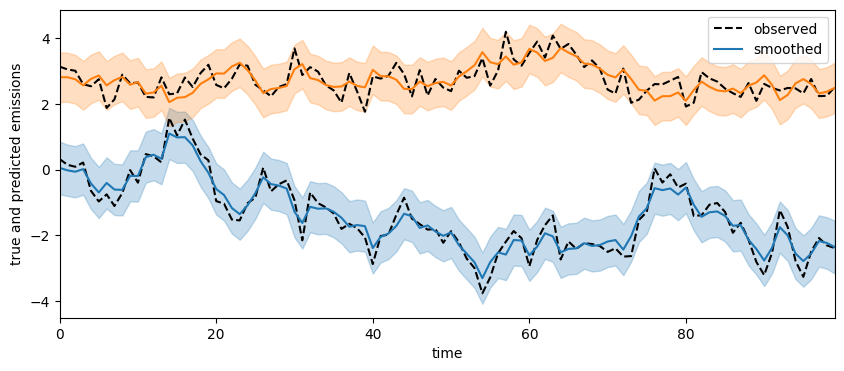

In [6]:
# Plot predictions from a random, untrained model

test_model = LinearGaussianConjugateSSM(state_dim, emission_dim)
key = jr.PRNGKey(420)
# dynamics_weights = jnp.eye(state_dim) + 0.1 * jr.normal(key, (state_dim, state_dim))
test_params, param_props = test_model.initialize(key,
                                                    # dynamics_weights=dynamics_weights
                                                    )

plot_predictions(true_model, true_params, test_model, test_params, emissions)


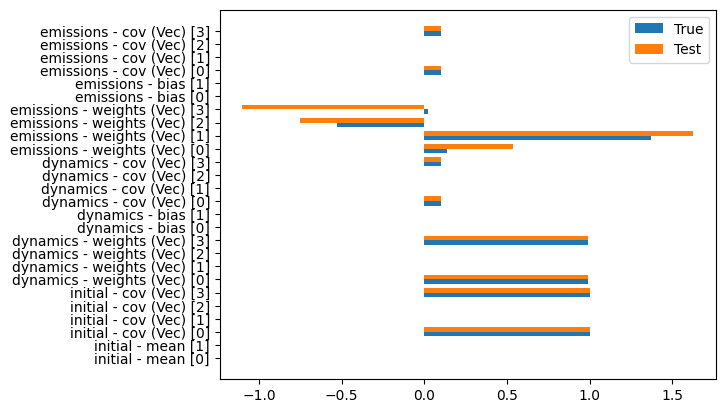

In [7]:
## Plot comparison of learned vs true parameters
compare_parameters2(true_params, test_params)

(1, 100, 2, 2)
(1, 100, 2)


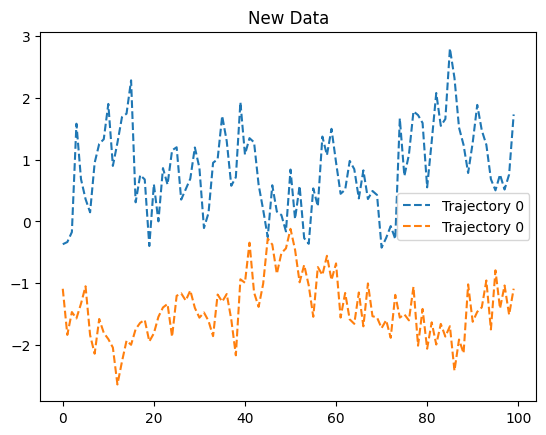

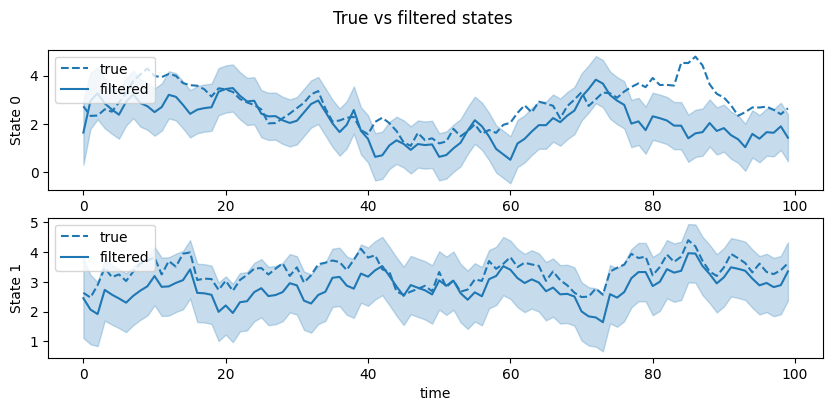

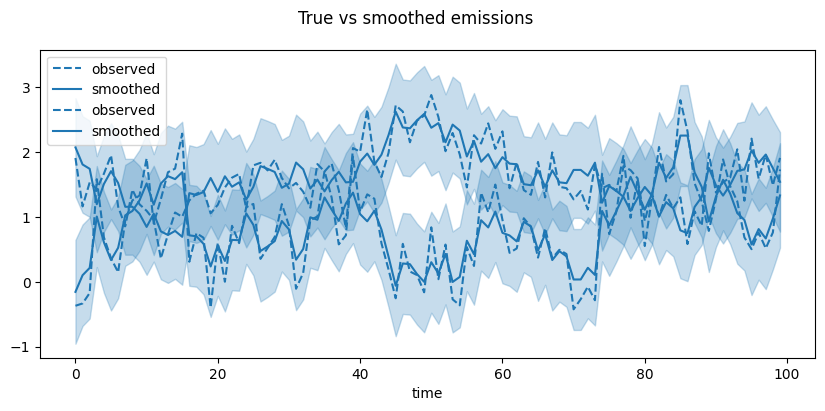

In [8]:
## Plot filtering and smoothing performance of learned model on independent test data generated from true model
plot_generalization(true_model, true_params, test_model, test_params, jnp.arange(num_timesteps), key, num_samples=1)

## Fit with EM

In [9]:
test_model = LinearGaussianConjugateSSM(state_dim, emission_dim)
key = jr.PRNGKey(42)
# dynamics_weights = jnp.eye(state_dim) + 0.1 * jr.normal(key, (state_dim, state_dim))
test_params, param_props = test_model.initialize(key, 
                                                #  dynamics_weights=dynamics_weights
                                                 )
num_iters = 500
test_params, marginal_lls = test_model.fit_em(test_params, param_props, emissions, num_iters=num_iters)

assert monotonically_increasing(marginal_lls, atol=1e-2, rtol=1e-2)

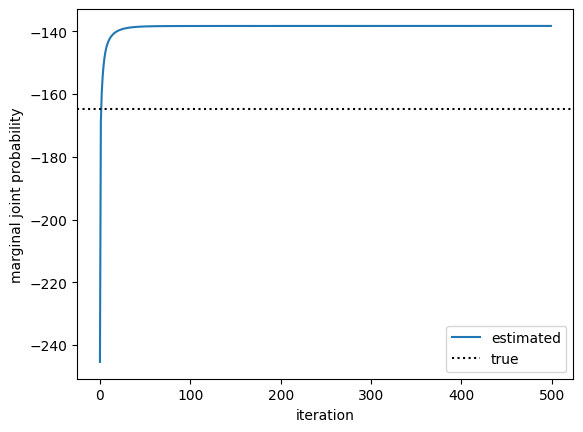

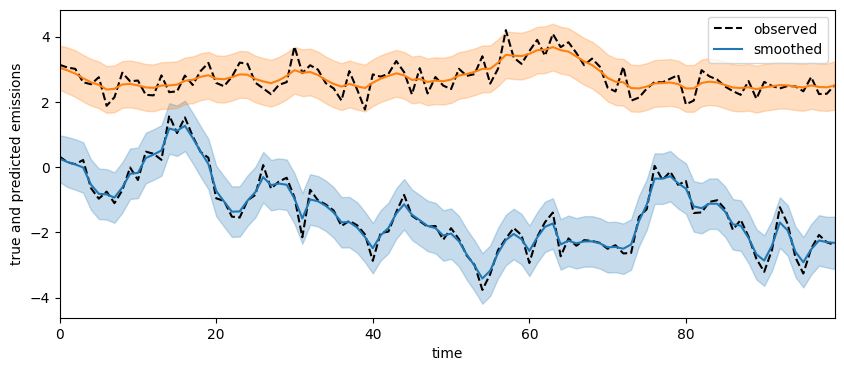

In [10]:
plot_learning_curve(marginal_lls, true_model, true_params, test_model, test_params, emissions)
plot_predictions(true_model, true_params, test_model, test_params, emissions)


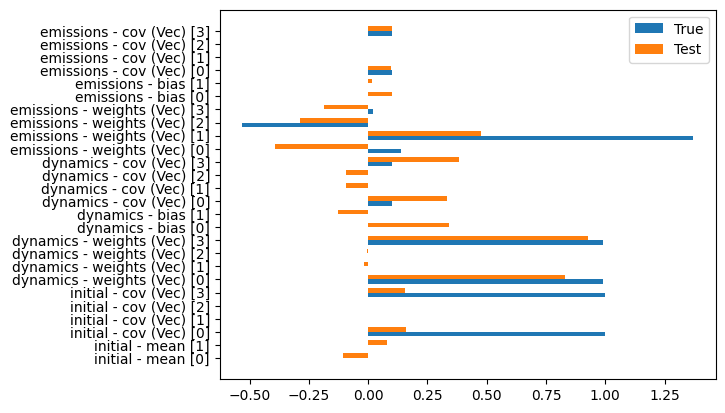

In [11]:
## Plot comparison of learned vs true parameters
compare_parameters2(true_params, test_params)

(1, 100, 2, 2)
(1, 100, 2)


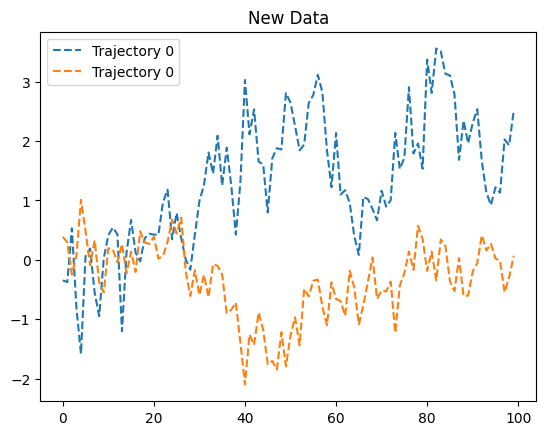

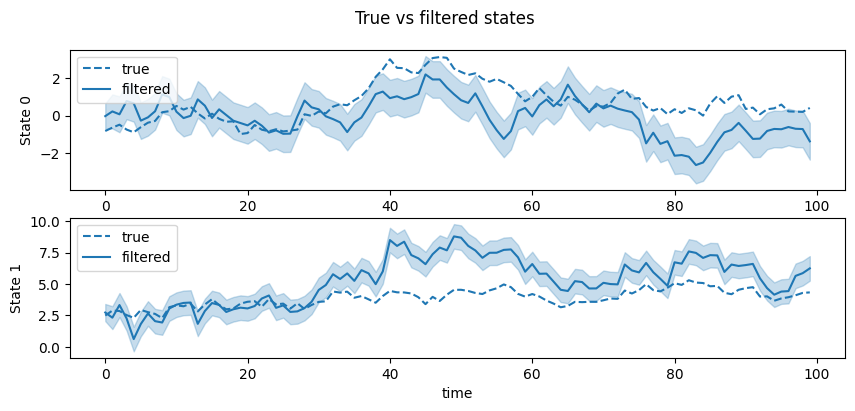

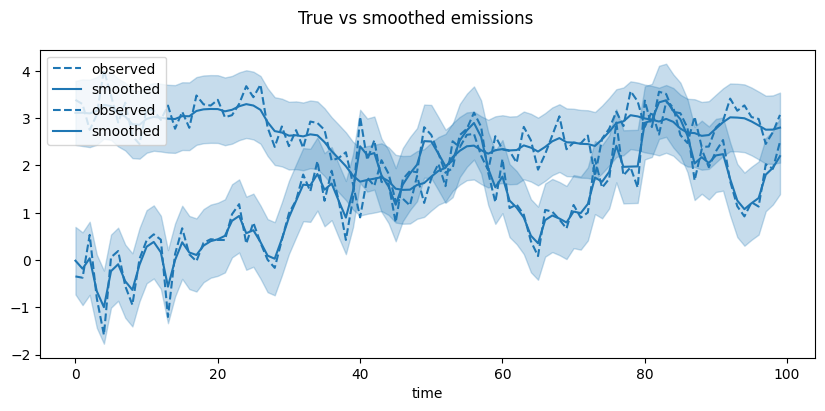

In [12]:
## Plot filtering and smoothing performance of learned model on independent test data generated from true model
plot_generalization(true_model, true_params, test_model, test_params, jnp.arange(num_timesteps), key, num_samples=1)

## Fit with SGD

In [13]:
test_model = LinearGaussianConjugateSSM(state_dim, emission_dim)
key = jr.PRNGKey(42)
# dynamics_weights = jnp.eye(state_dim) + 0.1 * jr.normal(key, (state_dim, state_dim))
num_iters = 200
test_params, param_props = test_model.initialize(key, 
                                                #  dynamics_weights=dynamics_weights
                                                 )

test_params, neg_marginal_lls = test_model.fit_sgd(test_params, param_props, emissions, num_epochs=num_iters * 20)
marginal_lls = -neg_marginal_lls * emissions.size

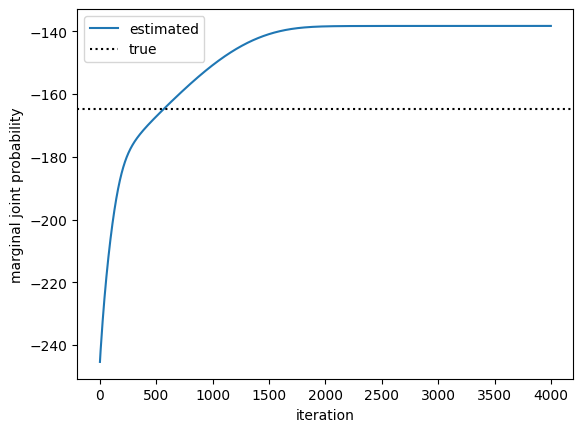

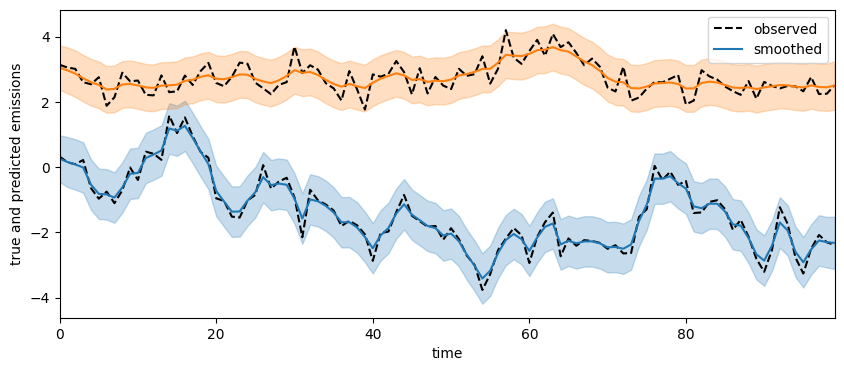

In [14]:
plot_learning_curve(marginal_lls, true_model, true_params, test_model, test_params, emissions)
plot_predictions(true_model, true_params, test_model, test_params, emissions)


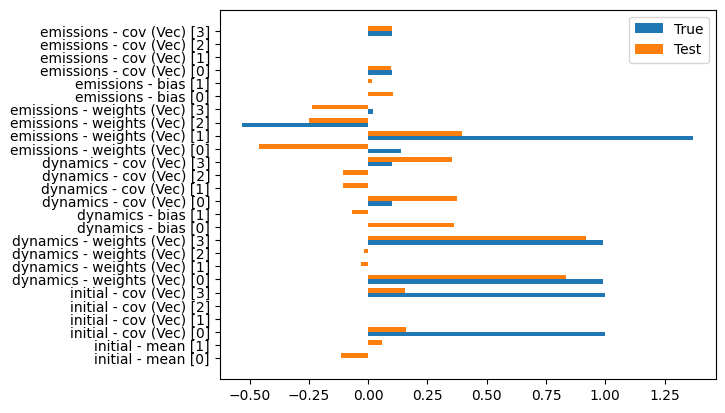

In [15]:
## Plot comparison of learned vs true parameters
compare_parameters2(true_params, test_params)


(1, 100, 2, 2)
(1, 100, 2)


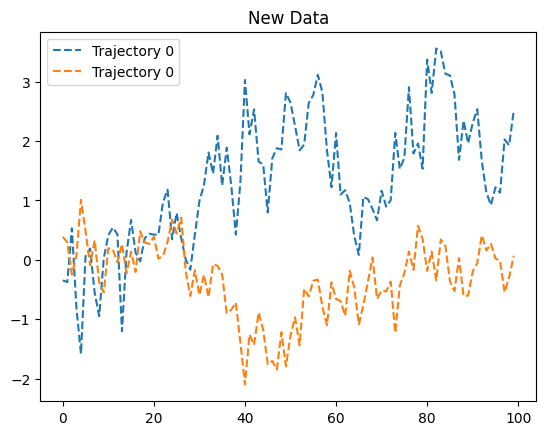

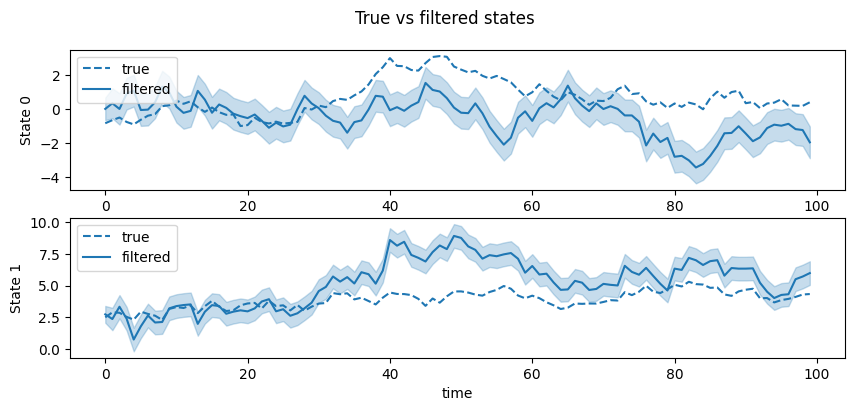

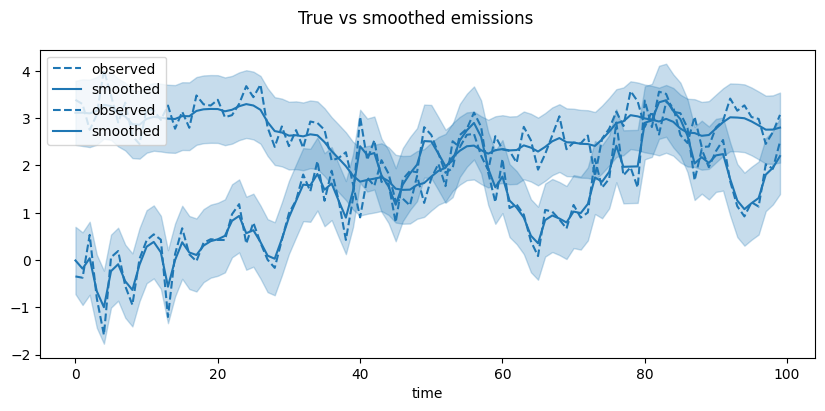

In [16]:
## Plot filtering and smoothing performance of learned model on independent test data generated from true model
plot_generalization(true_model, true_params, test_model, test_params, jnp.arange(num_timesteps), key, num_samples=1)